We first define our environment by implementing:
- `get_input_prompt` which returns a prompt for the model to respond to 
- and `score_generation` which scores the models completions according to our reward model - in this case a pretrained sentiment analysis model.

In [1]:
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    AutoModelForTokenClassification
)

from minRLHF.environment import Environment
import random
from transformers.pipelines import pipeline

reward_model = pipeline(
    "text-classification",
    model='bhadresh-savani/distilbert-base-uncased-emotion', 
    return_all_scores=True
)

class MyEnv(Environment):
    def get_input_prompt(self) -> str:
        return random.choice([
            'I went for a walk one day and',
            'A long time ago, in a galaxy far far away',
            'Oops! I'
        ])
        
    def score_generation(self, text: str) -> float:
        sentiment_scores = reward_model(text)[0]
        sentiment_scores = {d['label']: d['score'] for d in sentiment_scores}
        return sentiment_scores['joy']

/home/ubuntu/minRLHF/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/minRLHF/.venv/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


We require 3 transformers for PPO
1. `model` the language model we'll be optimising
2. `reference` a copy of the the language model that doesn't get optimised. PPO will penalise any updates that leave `model` too far away from `reference`.
3. `critic` used to decide what spans of the generation contributed to high/low rewards.

The env takes a tokenizer, and will handle translation from the model domain and back.

In [2]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = 'left'

model = AutoModelForCausalLM.from_pretrained('gpt2').to('cuda')
reference = AutoModelForCausalLM.from_pretrained('gpt2').to('cuda')
critic = AutoModelForTokenClassification.from_pretrained('gpt2', num_labels=1).to('cuda')

# Instantiate envrionment
env = MyEnv(tokenizer, batch_size=32)

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.2.attn.masked_bias', 'h.4.attn.masked_bias', 'h.8.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.3.attn.masked_bias', 'classifier.weight', 'classifier.bias', 'h.0.attn.masked_bias', 'h.10.attn.masked_bias', 'h.5.attn.masked_bias', 'h.9.attn.masked_bias', 'h.1.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We now create the PPO Trainer using the default arguments.

In [3]:
from minRLHF.ppo_trainer import PPOTrainer

# Create PPO trainer
ppo_trainer = PPOTrainer(
    actor_model=model,
    critic_model=critic,
    reference_model=reference,
    env=env,
    log_steps=20
)

In [4]:
ppo_trainer.train()

(Epoch:10 actor iter: 3) Early stopping due to kl of ~ 0.07794960553292185
(Epoch:15 actor iter: 1) Early stopping due to kl of ~ 0.11905228346586227
Completed epoch 19.
reward_mean: 0.4218469914492096
reward_std: 0.4336693298464969
augmented_reward: -2.0542066301737614
completion_length_mean: 87.40486330554812
completion_length_std: 8.593270750205308
kld_t-1: -0.06936095597179696
kld_0: -0.2388941554197446
entropy: 2.844676950658347

Completed epoch 39.
reward_mean: 0.4272964709241289
reward_std: 0.4277830696065565
augmented_reward: -6.29159349622074
completion_length_mean: 87.85746843609479
completion_length_std: 7.216559080485291
kld_t-1: -0.026202583147122056
kld_0: -0.977302173345351
entropy: 2.4105152700408707

(Epoch: 49) Saved model to actor_49.model
Completed epoch 59.
reward_mean: 0.4385270238080286
reward_std: 0.4255471416972173
augmented_reward: -7.281851622218626
completion_length_mean: 87.96953933067161
completion_length_std: 7.174089840682527
kld_t-1: -0.0080193833569331

KeyboardInterrupt: 

Text(0, 0.5, 'mean reward')

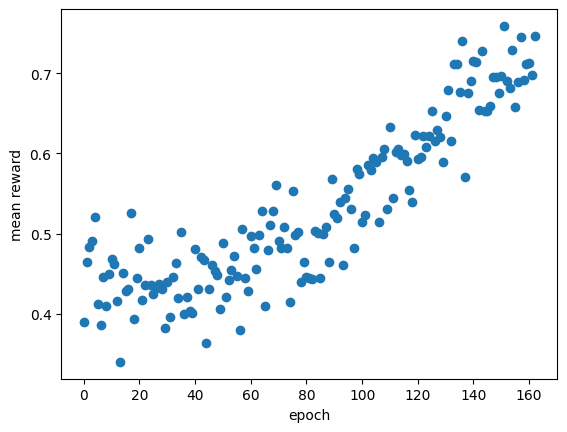

In [5]:
import matplotlib.pyplot as plt

xs = list(range(len(ppo_trainer.collected_rewards)))
ys = ppo_trainer.collected_rewards

plt.scatter(xs, ys)
plt.xlabel('epoch')
plt.ylabel('mean reward')

In [10]:
# You can load a saved checkpoint if you wish
# tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModelForCausalLM.from_pretrained('actor_99.model')

In [13]:
# Try out some generations

inputs = tokenizer('Yesterday, I', return_tensors='pt')
outputs = model.generate(inputs.input_ids.to(model.device), do_sample=True, max_length=100)
print(tokenizer.decode(outputs[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Yesterday, I got the whole news that Tom Curry, who was the new coach of the Warriors, was going to be taking a new team to L.A., but it seems like they're looking up at the Lakers.

I'm kind of like, "Why would they bring this back to that point when this team was really good that year when they really played really good football?"

They'd been in a different league and that team was so good for so long. Now,
